# Terrence Thesis - Case Study

### Import Statements 
# Jana tries to change something

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys

%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
matplotlib version: 2.2.2
flopy version: 3.2.9


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

In [7]:
nrow = 1
d = 10
ncol = 75 + d * 2
nlay = 10

Lx = 750 + 10 * d * 2
Ly = 25

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 20 + d, 23 + d ):
    top[ :, i ] = 31
for i in range ( 37 + d, 38 + d ):
    top[ :, i ] = 28
for j in range ( 40 + d, 55 + d ):
    top[ :, j ] = 32

# N1 layer
botm[ 0, :, : ] = 28
for i in range ( 37 + d, 39 + d ):
    botm[ 0, :, i ] = 28
# N2 layer
for i in range ( 0, 36 + d ):
    botm[ 1, :, i ] = 24
for i in range ( 36 + d, 38 + d ):
    botm[ 1, :, i ] = 25
for i in range ( 38 + d, 57 + d ):
    botm[ 1, :, i ] = 26
for i in range ( 57 + d, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 23 + d ):
    botm[ 2, :, i ] = 20
for i in range ( 23 + d, 36 + d ):
    botm[ 2, :, i ] = 21.5
for i in range ( 36 + d, 38 + d ):
    botm[ 2, :, i ] = 24
for i in range ( 38 + d, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 37 + d ):
    botm[ 3, :, i ] = 17
for i in range ( 37 + d, 40 + d ):
    botm[ 3, :, i ] = 16
for i in range ( 40 + d, 50 + d ):
    botm[ 3, :, i ] = 15
for i in range ( 50 + d, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 40 + d ):
    botm[ 4, :, i ] = 15
for i in range ( 40 + d, 50 + d ):
    botm[ 4, :, i ] = 14
for i in range ( 50 + d, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 50 + d ):
    botm[ 5, :, i ] = 13
for i in range ( 50 + d, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 3521

perlen = 1
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True

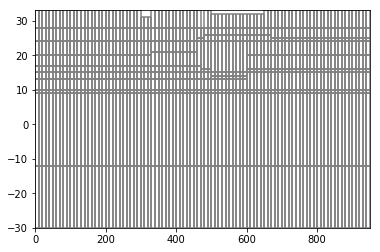

In [8]:
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=True
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 37 + d, 39 + d ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28
strt[ 1, :, 1 ] = 28
strt[ 1, :, -1 ] = 28

for i in range ( 20 + d, 23 + d ):
    strt[ 0, :, i ] = 30
for j in range ( 40 + d, 55 + d ):
    strt[ 0, :, j ] = 30
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [10]:
csv = pd.read_csv('SPA101.csv', delimiter=',')
chd_values = csv.iloc[ :, 2 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [11]:
sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2.csv', delimiter=',' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3.csv', delimiter=',' ).iloc[ :, 1 ].values

for col in range ( 20 + d, 23 + d ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1450 ] )
    
for col in range ( 40 + d, 55 + d ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1500 ] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 20 + d, 23 + d ):
        sp[ stress_period ].append ( [ 0, 0, col, 29 + 2.5*bas3_data[ stress_period - 1 ], 1800 ] )
    for col in range ( 40 + d, 55 + d ):
        sp[ stress_period ].append ( [ 0, 0, col, 28.5 + 5*bas12_data[ stress_period - 1 ], 2000 ] )

ghb = mf.ModflowGhb (tm, stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [12]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well.csv', delimiter=',').iloc[:, -2].values

spwell = {}
spwell[0] = [8, 0, 31 + d, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 31 + d, -wel_data[i-1]]

wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soilproperties and Flow-Package

In [13]:
k1 = 2   # fine sand 1.728-7.776
k2 = 34  # middle sand 7.776-34.56
k3 = 41  # stone 34.56-103.68
k4 = 1   # clay
k5 = 45  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range(20 + d, 50 + d):
    hk[2, :, i] = k3  # sand & stone
for i in range(45 + d, 57 + d):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range(20 + d, 34 + d):
    hk[4, :, i] = k3  # sand & stone
for i in range(34 + d, 38 + d):
    hk[4, :, i] = k4  # clay
for i in range(38 + d, 50 + d):
    hk[4, :, i] = k3  # sand & stone
for i in range(50 + d, 55 + d):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(26 + d, 40 + d):
    hk[5, :, i] = k6  # fine sand
for i in range(40 + d, 50 + d):
    hk[5, :, i] = k3  # sand & stone
for i in range(50 + d, 55 + d):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(26 + d, 40 + d):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2

# vertical HK
vk1 = 4
vk2 = 15
vk3 = 20
vk4 = 0.5
vk5 = 20
vk6 = 3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk3

# N1 layer
vka[0, :, :] = vk1  # fine sand

# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range(20 + d, 45 + d):
    vka[2, :, i] = vk3  # sand & stone
for i in range(45 + d, 57 + d):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range(20 + d, 34 + d):
    vka[4, :, i] = vk3  # sand & stone
for i in range(34 + d, 38 + d):
    vka[4, :, i] = vk4  # clay
for i in range(38 + d, 50 + d):
    vka[4, :, i] = vk3  # sand & stone
for i in range(50 + d, 55 + d):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range(26 + d, 40 + d):
    vka[5, :, i] = vk6  # fine sand
for i in range(40 + d, 50 + d):
    vka[5, :, i] = vk3  # sand & stone
for i in range(50 + d, 55 + d):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range(26 + d, 40 + d):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sy = 0.17
ss = 1e-4

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

#lpf.plot()

### Setup Solver Package and Output-control with defaults

In [14]:
budgetfile = '{}.cbb'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['print head', 'print budget','print drawdown', 'save head', 'save budget','save drawdown'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )

pcg = mf.ModflowPcg (tm, rclose=1e-1)

### Write Model input and run the model

In [15]:
tm.write_input()
success, buff = tm.run_model()

FloPy is using the following executable to run the model: C:\wrdapp\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/09/25 14:32:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water 

 Solving:  Stress period:   117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Wa

 Solving:  Stress period:   229    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     1    Ground-Wa

 Solving:  Stress period:   348    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:     1    Ground-Wa

 Solving:  Stress period:   473    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   478    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   479    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   480    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   481    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   482    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   483    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   484    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   485    Time step:     1    Ground-Wa

 Solving:  Stress period:   593    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   594    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   595    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   596    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   597    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   598    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   599    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   600    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   601    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   602    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   603    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   604    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   605    Time step:     1    Ground-Wa

 Solving:  Stress period:   700    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   701    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   702    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   703    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   704    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   705    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   706    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   707    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   708    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   709    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   710    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   711    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   712    Time step:     1    Ground-Wa

 Solving:  Stress period:   815    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   816    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   817    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   818    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   819    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   820    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   821    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   822    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   823    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   824    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   825    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   826    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   827    Time step:     1    Ground-Wa

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/09/25 14:32:08
 Elapsed run time:  6.593 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


### Read Observations

In [16]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells
#well 157
ts1 = headobj.get_ts ( idx=(1, 0, 55 + d) )

# todo: implement HOB-Package